In [190]:
import yfinance as yf
import pandas as pd
import numpy as np

# Example stock list



In [191]:
def getTimeMatrix(stocks, start, end):
    X = yf.download(stocks[0], start = start, end=end)["Close"]
    for tckr in stocks[1:]:
        X = X.join(yf.download(tckr, start = start, end=end)["Close"], how="inner")

    return X.values.transpose(), X.transpose()

In [192]:
def normalizeStockData(X):
    # Subtract mean
    X_centered = X - X.mean(axis=1, keepdims=True)

    # Divide by standard deviation
    X_std = X_centered / X_centered.std(axis=1, keepdims=True)

    return X_std

In [193]:
def getMeanAndSampleCovariance(X):
    # Note that X is N x T so each row is what we want
    m = np.mean(X, axis = 1)
    N, T = X.shape
    SHat = np.zeros((N,N))
    for i in range(len(X[0])):
        x_t = (X[:,i] - m)[:, np.newaxis] # The slice makes it a 1D array with shape (N,) so I reshaped with np.newaxis to a column vector (Nx1)
        SHat += x_t @ x_t.transpose()  # (N x 1) @ (1 x N) => N x N
    SHat /= T
    
    return m, SHat

In [205]:
from sklearn.linear_model import Lasso

def glasso(X, m, coVar, l1=0.03):
    initialization_scalar = 0.01
    conv_threshold = 1e-4
    maxIter = 100

    N = coVar.shape[0]
    W = initialization_scalar * np.eye(N) + coVar # Sparse matrix
    # W = np.eye(N)

    iter = 1
    rel_diff = conv_threshold + 1

    while ((rel_diff > conv_threshold) and (iter < maxIter)):
        W_old = W.copy()
        for i in range(N):
            W11 = np.delete(W, i, axis=0)  # remove row i
            W11 = np.delete(W11, i, axis=1)  # remove col i
            w12 = np.delete(W[:, i], i)
            s12 = np.delete(coVar[:, i], i)

            # Lasso subproblem
            lasso = Lasso(alpha=l1, fit_intercept=False, max_iter=1000)
            lasso.fit(W11, s12)
            beta = lasso.coef_

            # Update new elements of W
            w12 = W11 @ beta
            indices = np.arange(N) != i
            W[i, indices] = w12
            W[indices, i] = w12
            W[i, i] = 1.0 / (coVar[i, i] - s12 @ beta)

        # Frobenius norm to check convergence. Frobeneus norm of matrix A is sqrt(trace(A^T*A))
        diff = np.linalg.norm(W - W_old, ord='fro')
        rel_diff = diff / np.linalg.norm(W_old, ord='fro')
        iter +=1
    
    return W

In [195]:
def getWeights(S):
    N = S.shape[0]
    ones_col = np.ones((N, 1))
    return (S@ones_col)/(ones_col.T @ (S @ ones_col))

In [222]:
from scipy.optimize import minimize

def getWeightsNoNegative(S):
    """
    Given a covariance matrix S (n x n), compute the minimum variance portfolio
    weights under long-only constraint (weights >= 0 and sum to 1).
    """
    n = S.shape[0]
    init_guess = np.ones(n) / n  # Start with equal weights

    # Objective: portfolio variance = w^T S w
    def portfolio_variance(w, S):
        return w.T @ S @ w

    # Constraints: sum of weights = 1
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    
    # Bounds: long-only => weights between 0 and 1
    bounds = [(0.0, 1.0) for _ in range(n)]

    result = minimize(portfolio_variance,
                      init_guess,
                      args=(S,),
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)

    if not result.success:
        raise ValueError("Optimization failed:", result.message)

    return result.x



In [201]:
symbols = ["AAPL", "JNJ", "XOM", "WMT", "JPM"]
X, pdX = getTimeMatrix(symbols, start = "2020-01-01", end="2025-01-01")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [202]:
X_n = normalizeStockData(X)


In [203]:
m, coVar = getMeanAndSampleCovariance(X_n)

In [207]:
S = glasso(X_n, m, coVar)

In [ ]:
portfolioWeights = getWeights(S)


array([[0.25665785],
       [0.13836935],
       [0.19715826],
       [0.19867254],
       [0.20914201]])

In [225]:
for i, weight in enumerate(getWeightsNoNegative(S)):
    print(f"{symbols[i]}: {round((weight*100), 2)}%")

AAPL: 4.35%
JNJ: 42.95%
XOM: 15.83%
WMT: 20.8%
JPM: 16.07%


In [217]:
invCoVar = np.linalg.inv(coVar)
for i, weight in enumerate(getWeights(invCoVar)):
    print(f"{symbols[i]}: {round((weight[0]*100), 2)}%")

AAPL: -51.85%
JNJ: 58.51%
XOM: 15.45%
WMT: 66.3%
JPM: 11.59%


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_heatmap(W, tickers=None, title="Precision Matrix Heatmap"):
    plt.figure(figsize=(8, 6))
    im = plt.imshow(W, cmap='bwr', interpolation='nearest')

    # Add colorbar
    cbar = plt.colorbar(im, label='Value')

    # Add text annotations
    N = W.shape[0]
    for i in range(N):
        for j in range(N):
            value = W[i, j]
            plt.text(j, i, f"{value:.2f}", ha='center', va='center',
                     color='black' if abs(value) < 0.5 else 'white')

    # Set axis labels
    if tickers is not None and len(tickers) == N:
        plt.xticks(np.arange(N), tickers, rotation=45, ha='right')
        plt.yticks(np.arange(N), tickers)
    else:
        plt.xlabel("Variable index")
        plt.ylabel("Variable index")

    plt.title(title)
    plt.tight_layout()
    plt.show()


In [181]:
# symbols = ["AAPL", "MSFT", "GOOGL", "AMZN", "JPM"]
# symbols = ["AAPL", "JNJ", "XOM", "WMT", "JPM"]
# symbols = ["NVDA", "PFE", "CVX", "COST", "GS", "CAT", "DIS"]
symbols = ["S", "^GSPC"]

X, pdX = getTimeMatrix(symbols, start = "2020-01-01", end="2025-01-01")

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


In [182]:
X = normalizeStockData(X)
m, coVar = getMeanAndSampleCovariance(X)

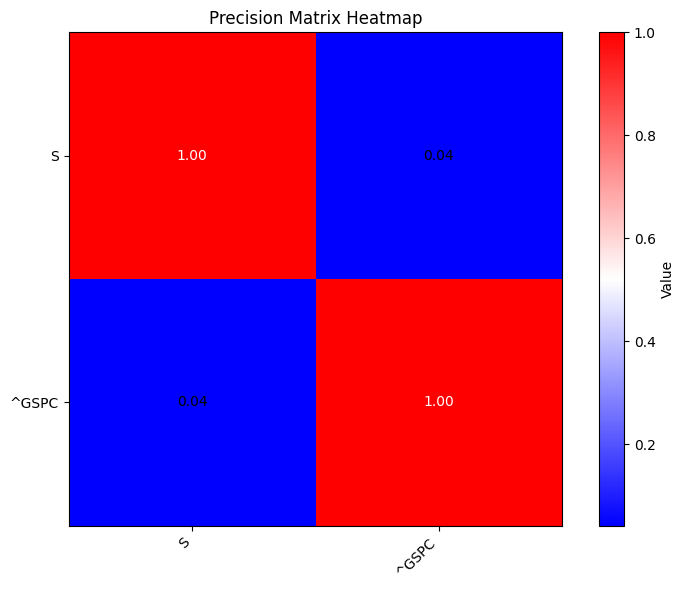

In [183]:
plot_heatmap(coVar, tickers=symbols)

In [184]:
sparse = glasso(X, m, coVar, l1=0.03)

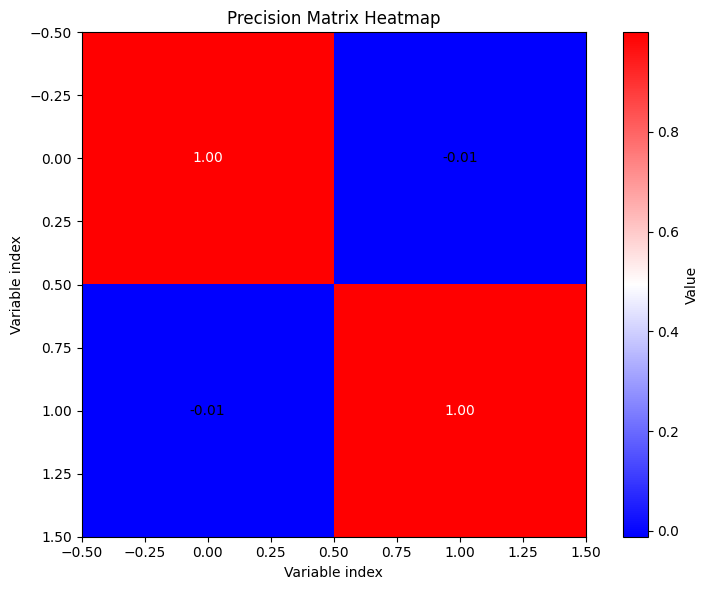

In [185]:
plot_heatmap(np.linalg.inv(sparse))

In [186]:

from sklearn import covariance
alphas = np.logspace(-1.5, 1, num=10)

X, pdX = getTimeMatrix(symbols, start = "2020-01-01", end="2025-01-01")

X_std = X.copy()
X_std /= X.std(axis=0)

edge_model = covariance.GraphicalLassoCV(alphas=alphas)
edge_model.fit(X_std.T)
lambda_best = edge_model.alpha_

print("Estimated location (mean):")
print(edge_model.location_)

print("\nEstimated covariance matrix:")
print(edge_model.covariance_)

print("\nEstimated precision matrix (inverse covariance):")
print(edge_model.precision_)

print("\nSelected penalization alpha:")
print(edge_model.alpha_)

print("\nNumber of iterations for optimal alpha:")
print(edge_model.n_iter_)

# If you enabled return_costs=True
if hasattr(edge_model, "costs_"):
    print("\nObjective and dual gap per iteration:")
    for obj, gap in edge_model.costs_:
        print(f"Objective: {obj:.4f}, Dual gap: {gap:.4e}")

# Cross-validation results
print("\nAll alphas explored:")
print(edge_model.cv_results_['alphas'])

print("\nMean test score per alpha:")
print(edge_model.cv_results_['mean_test_score'])

print("\nStd dev of test score per alpha:")
print(edge_model.cv_results_['std_test_score'])


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

Estimated location (mean):
[0.01237576 2.01237576]

Estimated covariance matrix:
[[4.14422306e-05 0.00000000e+00]
 [0.00000000e+00 4.14422306e-05]]

Estimated precision matrix (inverse covariance):
[[24129.97529339    -0.        ]
 [   -0.         24129.97529339]]

Selected penalization alpha:
0.03162277660168379

Number of iterations for optimal alpha:
1

Objective and dual gap per iteration:
Objective: -10.8309, Dual gap: 0.0000e+00

All alphas explored:
[10.          5.27499706  2.7825594   1.46779927  0.77426368  0.40842387
  0.21544347  0.11364637  0.05994843  0.03162278  0.        ]

Mean test score per alpha:
[7.93264184 7.93264184 7.93264184 7.93264184 7.93264184 7.93264184
 7.93264184 7.93264184 7.93264184 7.93264184       -inf]

Std dev of test score per alpha:
[0.30076625 0.30076625 0.30076625 0.30076625 0.30076625 0.30076625
 0.30076625 0.30076625 0.30076625 0.30076625        nan]



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


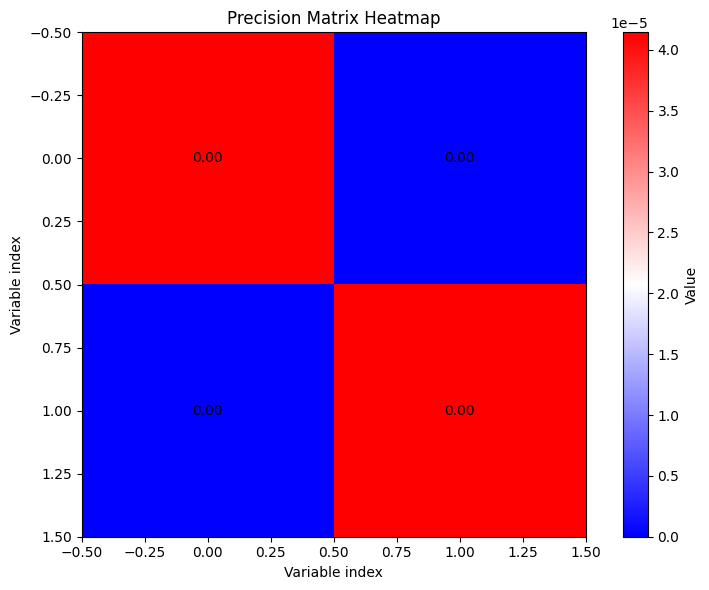

In [187]:
plot_heatmap(edge_model.covariance_)

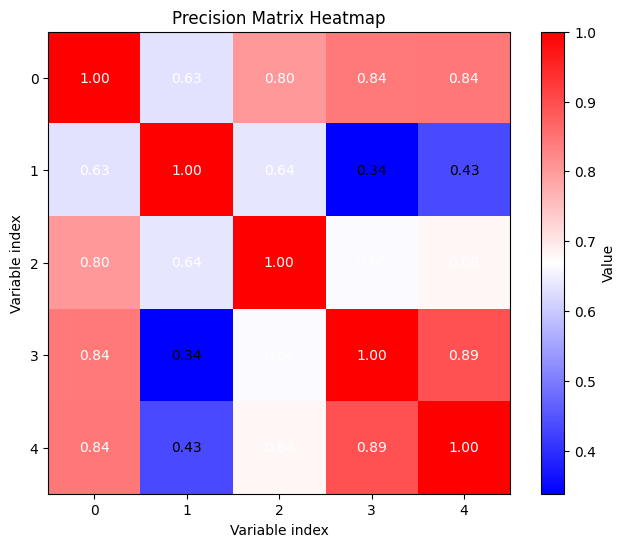

In [151]:
plot_heatmap(coVar)

In [93]:
from sklearn import covariance
import numpy as np

def glasso_sk(X):
    """
    Uses sklearn's GraphicalLassoCV to fit a sparse precision matrix.

    Args:
        X: np.array, shape (T, N)
           Standardized data matrix (T = time, N = variables)

    Returns:
        precision_: estimated sparse precision matrix (N x N)
        covariance_: estimated covariance matrix (N x N)
    """
    alphas = np.logspace(-1.5, 1, num=10)

    # Standardize: zero mean, unit variance for each variable
    X_std = X.copy()
    X_std /= X.std(axis=0)

    edge_model = covariance.GraphicalLassoCV(alphas=alphas)
    edge_model.fit(X_std)

    return edge_model.precision_, edge_model.covariance_


In [94]:
precision_sk, covariance_sk = glasso_sk(X.T)

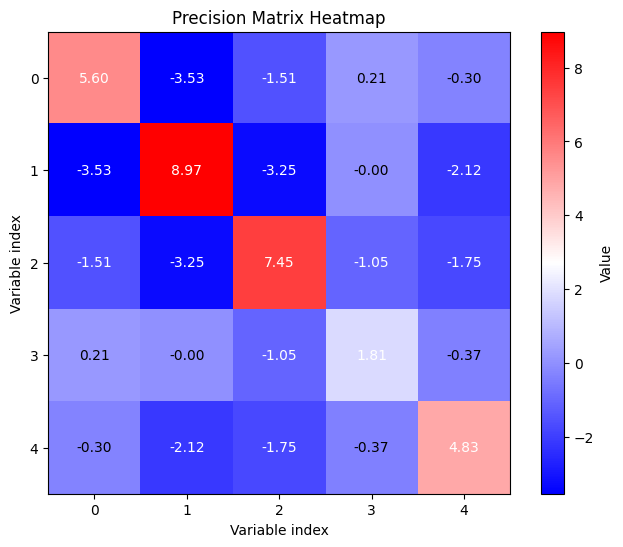

In [95]:
plot_heatmap(precision_sk)

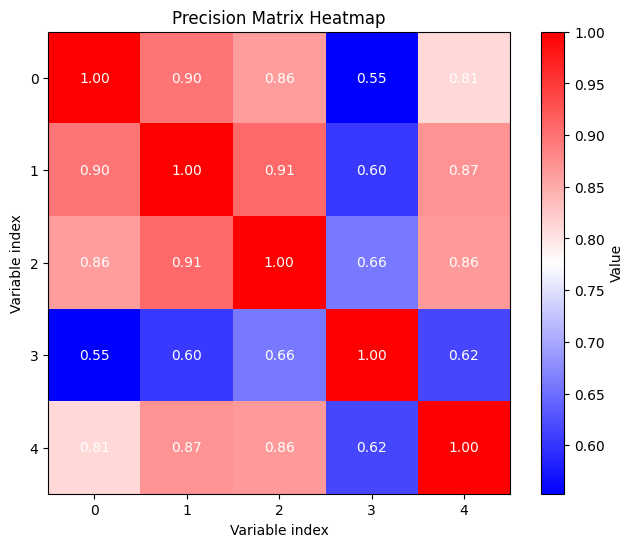

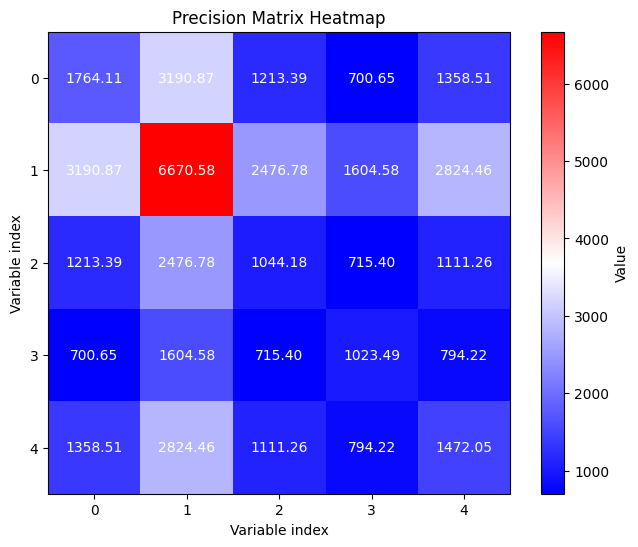

In [ ]:
plot_heatmap(covariance_sk)

In [58]:
m_np = np.mean(X, axis=1)
Sigma_np = np.cov(X, bias=True)

In [60]:
Sigma_np

array([[1764.11178284, 3190.87484335, 1213.38541754,  700.65297801,
        1358.50608547],
       [3190.87484335, 6670.58082973, 2476.77818222, 1604.57554315,
        2824.45832244],
       [1213.38541754, 2476.77818222, 1044.18230094,  715.40408352,
        1111.25714893],
       [ 700.65297801, 1604.57554315,  715.40408352, 1023.48643344,
         794.22132813],
       [1358.50608547, 2824.45832244, 1111.25714893,  794.22132813,
        1472.05080457]])

In [ ]:
aapl = yf.download("AAPL", start = "2020-01-01", end="2025-01-01")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
aapl.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.620834,72.681281,71.373211,71.627084,135480400
2020-01-03,71.914818,72.676447,71.689957,71.847118,146322800
2020-01-06,72.487869,72.526556,70.783271,71.034732,118387200
2020-01-07,72.146927,72.753808,71.926900,72.497514,108872000
2020-01-08,73.307518,73.609752,71.849540,71.849540,132079200


In [4]:
type(aapl)

pandas.core.frame.DataFrame

In [5]:
msft  = yf.download("MSFT", start = "2020-01-01", end="2025-01-01")

[*********************100%***********************]  1 of 1 completed


In [14]:
comb = aapl["Close"].join(msft['Close'], how = "inner")

In [15]:
comb.head()

Ticker,AAPL,MSFT
Date,,
2020-01-02,72.620834,153.042297
2020-01-03,71.914818,151.136642
2020-01-06,72.487869,151.527298
2020-01-07,72.146927,150.145721
2020-01-08,73.307518,152.537323


In [16]:
X = comb.values

In [25]:
X = X.transpose()

In [26]:
X.shape

(2, 1258)

In [52]:

arr_1d = np.array([1, 2, 3, 4, 5, 6])

# Add a new axis to make it a column vector (N rows, 1 column)
arr_2d_col = arr_1d[:, np.newaxis]
print("Using np.newaxis (column vector):\n", arr_2d_col)

# Add a new axis to make it a row vector (1 row, N columns)
arr_2d_row = arr_1d[np.newaxis, :]
print("Using np.newaxis (row vector):\n", arr_2d_row)

Using np.newaxis (column vector):
 [[1]
 [2]
 [3]
 [4]
 [5]
 [6]]
Using np.newaxis (row vector):
 [[1 2 3 4 5 6]]


In [53]:
arr_2d_col.shape

(6, 1)